In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sep
from matplotlib.patches import Ellipse
from astropy.wcs import WCS
import seaborn as sns
from lenstronomy.Data.psf import PSF
from scipy.optimize import minimize

In [2]:
cutouts_4amin_path = './Data/4amin/'
pixel_scales = 20/120 #arcsec

In [3]:
hdu = fits.open(cutouts_4amin_path+'J083933.4-014044.4-HSC-I-pdr3_wide.fits')[1]
wcs = WCS(hdu.header)
wide = hdu.data
wide = wide.byteswap().newbyteorder()
m, s = np.mean(wide), np.std(wide)

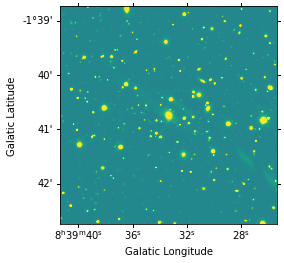

In [5]:
plt.subplot(projection=wcs)
plt.imshow(wide, vmin=m-s, vmax=m+s, origin='lower', cmap='viridis')
plt.xlabel('Galatic Longitude')
plt.ylabel('Galatic Latitude')
plt.savefig('./Images/WideFieldImage.jpg', dpi=400)

In [6]:
bkg = sep.Background(wide)
data_sub = wide - bkg

In [7]:
objects = sep.extract(data_sub, thresh=0.5, minarea=20, err=bkg.globalrms)
print('Number of detected objects:', len(objects))

Number of detected objects: 1248


In [8]:
len(data_sub)

1430

In [9]:
amin_asec_conversion = 4*240/1430

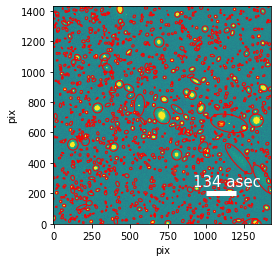

In [10]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')
ax.hlines(y=200, xmin=1000, xmax=1200, color='w', linestyle='-', zorder=2, lw=5)
ax.annotate(str(round(amin_asec_conversion*200))+' asec', (920, 250), c='w', fontsize=15, zorder=2)

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

ax.set_xlabel('pix')
ax.set_ylabel('pix')
fig.savefig('./Images/ObjSExtractorTotal.jpg', dpi=400);

In [12]:
SEXtractorDetection = pd.read_csv('./Results/test.cat',
                                  sep='\s+',
                                  comment='#',
                                  names=['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'XWIN_IMAGE', 'YWIN_IMAGE', 'XMODEL_IMAGE', 'YMODEL_IMAGE', 'MAG_AUTO', 'MAG_MODEL', 'FLUX_RADIUS', 'FLAGS', 'FLAGS_WIN', 'NITER_WIN', 'SPREAD_MODEL', 'SPREADERR_MODEL', 'ID_PARENT', 'CLASS_STAR', 'MAGERR_AUTO', 'XPEAK_IMAGE', 'YPEAK_IMAGE'])
print(len(SEXtractorDetection))

1236


In [13]:
SEXtractorDetection.head()

,NUMBER,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMODEL_IMAGE,YMODEL_IMAGE,MAG_AUTO,MAG_MODEL,FLUX_RADIUS,FLAGS,FLAGS_WIN,NITER_WIN,SPREAD_MODEL,SPREADERR_MODEL,ID_PARENT,CLASS_STAR,MAGERR_AUTO,XPEAK_IMAGE,YPEAK_IMAGE
0,1,1219.0216,429.1363,1221.9697,427.0245,1218.2716,429.8205,-7.9903,-8.0379,33.521,19,0,17,0.001386,0.000065,538,0.000,0.0088,1245,417
1,2,1378.4691,294.9915,1380.7394,292.3019,1383.5676,291.5087,-7.8442,-7.9677,30.464,19,0,17,0.005410,0.000338,412,0.000,0.0087,1384,289
2,3,1401.8721,107.2274,1401.6392,107.1598,1401.6253,107.1488,-7.6050,-7.6400,6.115,24,0,5,0.024295,0.000113,143,0.029,0.0032,1402,107
3,4,170.1670,82.8118,170.1007,82.7993,170.0810,82.7757,-4.7035,-4.7017,3.611,3,0,4,0.028701,0.000982,129,0.003,0.0288,170,82
4,5,566.8439,97.6835,566.8082,97.6083,566.7957,97.6199,-6.2640,-6.2519,4.300,0,0,6,0.021444,0.000212,125,0.033,0.0090,567,98


In [14]:
zp=2.5*np.log10(63095734448.01944)

In [15]:
SEXtractorDetection['MAG_AUTO'] = SEXtractorDetection['MAG_AUTO']+zp

Text(0, 0.5, 'f')

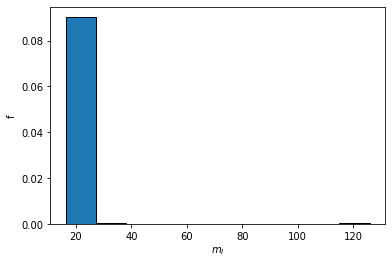

In [16]:
plt.hist(SEXtractorDetection['MAG_AUTO'], ec='k', density=True)
plt.xlabel('$m_I$')
plt.ylabel('f')

In [17]:
magautocut=np.percentile(SEXtractorDetection['MAG_AUTO'], 97)

In [18]:
magautocut

26.715889999999998

Text(0, 0.5, 'f')

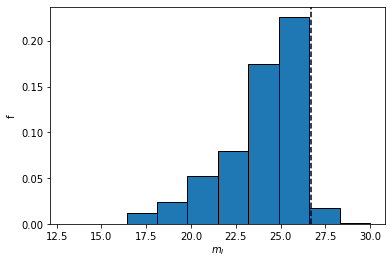

In [19]:
plt.hist(SEXtractorDetection['MAG_AUTO'], ec='k', density=True, range=(13, 30))
plt.axvline(x=magautocut, linestyle='--', zorder=2, c='k')
plt.xlabel('$m_I$')
plt.ylabel('f')
#plt.savefig('./result_images/magrange.png', dpi=300)

In [20]:
SEXtractorDetection= SEXtractorDetection[SEXtractorDetection['MAG_AUTO']< magautocut]
SEXtractorDetection= SEXtractorDetection[SEXtractorDetection['FLAGS']== 0]

SEXtractorDetection.reset_index(inplace=True)

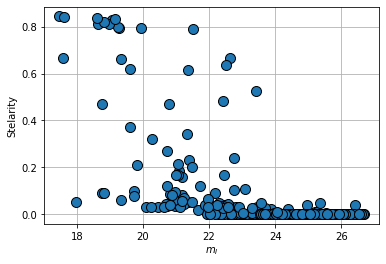

In [21]:
plt.scatter(SEXtractorDetection['MAG_AUTO'], SEXtractorDetection['CLASS_STAR'], ec='k', zorder=2, s=100)
#for i in range(0, len(SEXtractorDetection)):
    #plt.annotate(i, (SEXtractorDetection['MAG_AUTO'][i], SEXtractorDetection['CLASS_STAR'][i]), color='r', fontsize=15)

plt.xlabel('$m_I$')
plt.ylabel('Stelarity')
plt.grid()
#plt.savefig('./result_images/StelarMag.jpg', dpi=400);

In [22]:
SEXtractorDetection= SEXtractorDetection[SEXtractorDetection['CLASS_STAR'] > 0.7]
SEXtractorDetection.reset_index(inplace=True)
print(len(SEXtractorDetection))

12


In [23]:
SEXtractorDetection.head()

,level_0,index,NUMBER,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMODEL_IMAGE,YMODEL_IMAGE,MAG_AUTO,...,FLAGS,FLAGS_WIN,NITER_WIN,SPREAD_MODEL,SPREADERR_MODEL,ID_PARENT,CLASS_STAR,MAGERR_AUTO,XPEAK_IMAGE,YPEAK_IMAGE
0,26,90,91,1261.2316,105.5862,1261.3271,105.6515,1261.3218,105.6487,21.5130,...,0,0,4,0.013914,0.000178,123,0.789,0.0089,1261,106
1,100,284,285,857.4132,342.6047,857.3930,342.5292,857.3913,342.5326,19.2898,...,0,0,4,0.020012,0.000028,382,0.793,0.0013,857,343
2,105,299,300,800.5681,348.3125,800.5634,348.3038,800.5522,348.3102,19.9351,...,0,0,3,0.016574,0.000046,381,0.793,0.0023,801,348
3,161,470,471,76.0442,884.8365,76.0094,884.7568,76.0075,884.7663,17.4708,...,0,0,4,0.023493,0.000006,890,0.844,0.0003,76,885
4,186,521,522,116.0160,827.4495,115.9370,827.4771,115.9337,827.4641,19.0683,...,0,0,5,0.023137,0.000026,839,0.827,0.0011,116,827


Text(0, 0.5, 'pix')

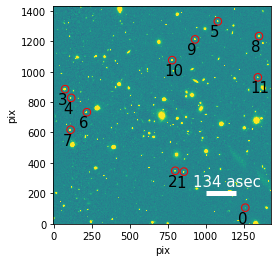

In [24]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='viridis',
               vmin=m-s, vmax=m+s, origin='lower')

ax.hlines(y=200, xmin=1000, xmax=1200, color='w', linestyle='-', zorder=2, lw=5)
ax.annotate(str(round(amin_asec_conversion*200))+' asec', (920, 250), c='w', fontsize=15, zorder=2)


# plot an ellipse for each object
for i in range(len(SEXtractorDetection)):
    ax.annotate(str(i), (SEXtractorDetection['X_IMAGE'][i]-50, SEXtractorDetection['Y_IMAGE'][i]-100), fontsize=15, color='k')
    e = Ellipse(xy=(SEXtractorDetection['X_IMAGE'][i], SEXtractorDetection['Y_IMAGE'][i]),
                width=50*1.,
                height=50*1.,
                angle=0)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
ax.set_xlabel('pix')
ax.set_ylabel('pix')
#fig.savefig('./result_images/ObjSExtractorSelected.jpg', dpi=400);

In [25]:
SEXtractorDetection.head()

,level_0,index,NUMBER,X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMODEL_IMAGE,YMODEL_IMAGE,MAG_AUTO,...,FLAGS,FLAGS_WIN,NITER_WIN,SPREAD_MODEL,SPREADERR_MODEL,ID_PARENT,CLASS_STAR,MAGERR_AUTO,XPEAK_IMAGE,YPEAK_IMAGE
0,26,90,91,1261.2316,105.5862,1261.3271,105.6515,1261.3218,105.6487,21.5130,...,0,0,4,0.013914,0.000178,123,0.789,0.0089,1261,106
1,100,284,285,857.4132,342.6047,857.3930,342.5292,857.3913,342.5326,19.2898,...,0,0,4,0.020012,0.000028,382,0.793,0.0013,857,343
2,105,299,300,800.5681,348.3125,800.5634,348.3038,800.5522,348.3102,19.9351,...,0,0,3,0.016574,0.000046,381,0.793,0.0023,801,348
3,161,470,471,76.0442,884.8365,76.0094,884.7568,76.0075,884.7663,17.4708,...,0,0,4,0.023493,0.000006,890,0.844,0.0003,76,885
4,186,521,522,116.0160,827.4495,115.9370,827.4771,115.9337,827.4641,19.0683,...,0,0,5,0.023137,0.000026,839,0.827,0.0011,116,827


In [26]:
y_psf, x_psf = int(SEXtractorDetection.T[2]['XPEAK_IMAGE']), int(SEXtractorDetection.T[2]['YPEAK_IMAGE'])
delta_psf = 10

In [27]:
psf_image = wide[x_psf-delta_psf:x_psf+delta_psf-1, y_psf-delta_psf:y_psf+delta_psf-1] # odd shape (-1), necessary for AutoLens

Text(0, 0.5, 'pix')

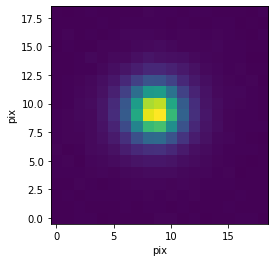

In [28]:
plt.imshow(psf_image, origin='lower', cmap='viridis')
plt.xlabel('pix')
plt.ylabel('pix')

In [29]:
psf_image.shape

(19, 19)

In [30]:
def chisquared(x):
    FlatPSFSExtractor = psf_image.flatten()
    
    # generate a PSF
    psf_class = PSF(
        psf_type='GAUSSIAN',
        fwhm=x[0],
        pixel_size=pixel_scales,
        truncation=3/x[0]
    )
    psf = x[1]*psf_class.kernel_point_source/np.max(psf_class.kernel_point_source)
    FlatPSF = psf.flatten()

    return np.sum((FlatPSFSExtractor - FlatPSF)**2)

In [31]:
x0 = np.array([0.7, 10])

In [32]:
res = minimize(chisquared, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 531.706680
         Iterations: 74
         Function evaluations: 155


In [33]:
seeing, norm = res.x
print(seeing, norm)

0.6842576003531893 30.998101409313875


In [34]:
# generate a PSF
psf_class = PSF(
    psf_type='GAUSSIAN',
    fwhm=seeing,
    pixel_size=pixel_scales,
    truncation=3/seeing
)
FitPSF = norm*psf_class.kernel_point_source/np.max(psf_class.kernel_point_source)


In [40]:
mean_seeing_survey = 0.61

psf_class = PSF(
    psf_type='GAUSSIAN',
    fwhm=mean_seeing_survey,
    pixel_size=pixel_scales,
    truncation=3/mean_seeing_survey
)
PSFSurvey = 10*psf_class.kernel_point_source/np.max(psf_class.kernel_point_source)

[]

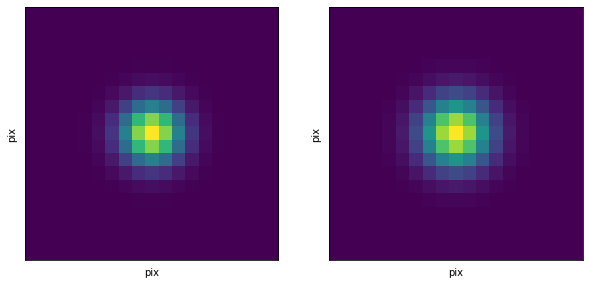

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10,20), sharey=True)

ax[0].imshow(PSFSurvey)
ax[0].set_xlabel('pix')
ax[0].set_xticks([])
ax[0].set_ylabel('pix')
ax[0].set_yticks([])

ax[1].imshow(FitPSF)
ax[1].set_xlabel('pix')
ax[1].set_xticks([])
ax[1].set_ylabel('pix')
ax[1].set_yticks([])

In [44]:
import scipy.stats as stats

Text(0, 0.5, 'Normalized flux (a.u.)')

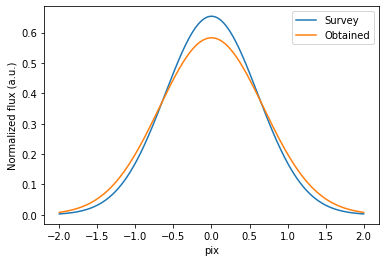

In [53]:
mu = 0

x = np.linspace(-2., 2., 1000)


plt.plot(x, stats.norm.pdf(x, mu, mean_seeing_survey), label='Survey')
plt.plot(x, stats.norm.pdf(x, mu, seeing), label='Obtained')
plt.legend()
plt.xlabel('pix')
plt.ylabel('Normalized flux (a.u.)')

In [54]:
# exporting the psf
hdu_image = fits.PrimaryHDU(data=FitPSF)
hdu_image.header['EXPTIME'] =  285
hdu_image.writeto('./Results/SExtractorPSF.fits', overwrite=True)